In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

from fb_env import Board

# Drawing game via seqience of moves

In [2]:
_,img,img_game = Board.play_sequence(["T","TL","TR","R","B","L","BR","BL"])

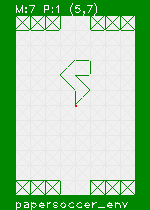

In [3]:
Image.fromarray(img)

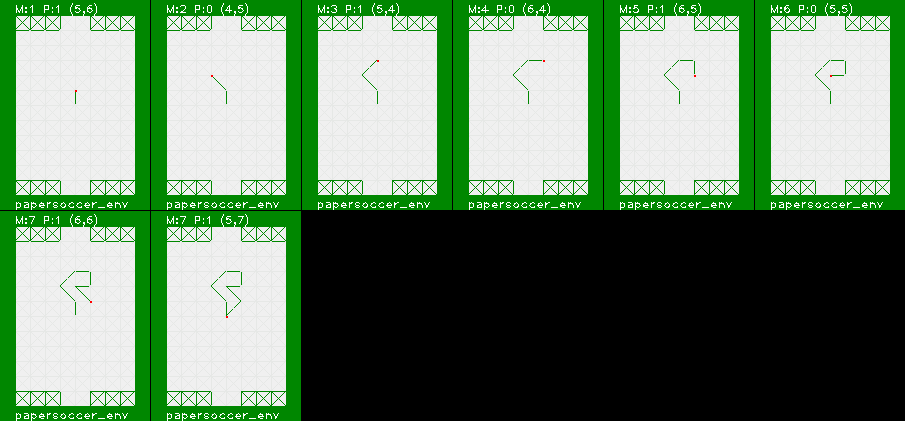

In [4]:
Image.fromarray(img_game)

# Random play

Move 9, Winner is: 0


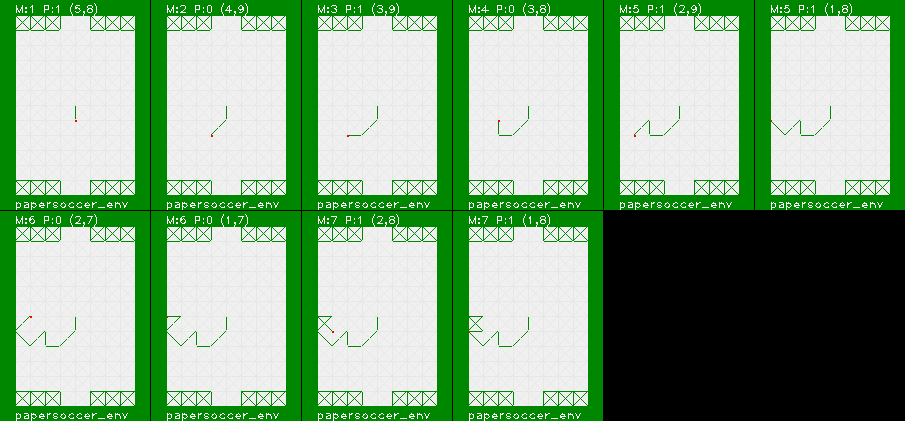

In [5]:
def random_play(board,moves=200):
    sequence = []
    for i in range(moves):
        moves_dict = board.possible_moves()
        moves = []
        for key in moves_dict:
            if moves_dict[key]:
                moves.append(key)

        index = np.random.randint(0,len(moves))
        sequence.append(moves[index])
        valid_move, next_player, winner = board.move(moves[index])

        if winner is not None:
            return i, winner, sequence

sb = Board()
i,winner, sequence = random_play(sb)
print(f"Move {i}, Winner is:", winner)
Image.fromarray(Board.play_sequence(sequence)[2])

# Random play stats


Moves mean:41.377 std:28.265577492773787 min:5 max:168
Winner mean:0.492 std:0.49993599590347565


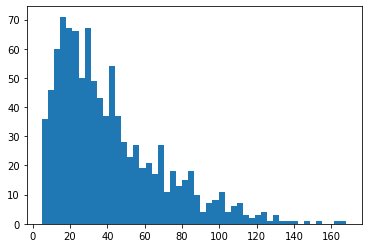

In [6]:
winners = []
moves = []
simulations = 1000
for i in tqdm(range(simulations)):
    sb = Board()
    i,winner, sequence = random_play(sb, moves=500)
    moves.append(i)
    winners.append(winner)
    
print(f"Moves mean:{np.mean(moves)} std:{np.std(moves)} min:{np.min(moves)} max:{np.max(moves)}")
print(f"Winner mean:{np.mean(winners)} std:{np.std(winners)}")

plt.hist(moves, bins = 50)
pass